In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
import scipy.sparse as sparse
import implicit
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# Data mining

In [2]:
df2 = pd.read_csv("./data/processed_data.csv", encoding="utf-8")

In [3]:
df2.head()

,user_id,order_id,time,description,product_id,product_name,amount,price
0,BDS49BDS,XBH011609/006,2016-09-05,Xuất bán T09/06- DYKEH ngày ETD 5/9/2016,LTSCORMH374SCA1,Corner Sofa Set_Middle_H374,68.0,1812.88
1,BDS49BDS,XBH011609/005,2016-09-05,Xuất bán T09/05- DYKEH ngày ETD 5/9/2016,LTSCORMH374SCA1,Corner Sofa Set_Middle_H374,68.0,1812.88
2,BDS49BDS,XBH011609/005,2016-09-05,Xuất bán T09/05- DYKEH ngày ETD 5/9/2016,LTSCORCH374SCA1,Corner Sofa Set_Corner_H374,34.0,1813.22
3,BDS49BDS,XBH011609/005,2016-09-05,Xuất bán T09/05- DYKEH ngày ETD 5/9/2016,LTSCOR1H374SCA1,Corner Sofa Set_ArmChair_H374,34.0,1813.22
4,BDS49BDS,XBH011609/004,2016-09-05,Xuất bán T09/04- DYKEH ngày ETD 5/9/2016,LTTCORVH374SCA1,Corner Sofa Set_Table_H374,34.0,1814.24


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 8 columns):
user_id         2415 non-null object
order_id        2415 non-null object
time            2415 non-null object
description     2415 non-null object
product_id      2415 non-null object
product_name    2415 non-null object
amount          2415 non-null float64
price           2415 non-null float64
dtypes: float64(2), object(6)
memory usage: 151.1+ KB


In [5]:
df2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,2415,45,AQU49LCW,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_id,2415,1132,XBH011606/026,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,2415,224,2017-01-21,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,2415,1131,Xuất bán T06/26 - LT9516CLFA ngày ETD 26/6/2016,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,2415,496,LTCGUD1F310SPA1,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,2415,495,Gudhjem Chair_F310,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,2415,NaN,NaN,NaN,382.737,567.262,1,14,78,720,5040
price,2415,NaN,NaN,NaN,5540.1,6231.51,0,637.2,2618,10080,31620


## Summary
- user
    - Total: 45
    - Most freq buyer: AQU49LCW (422 times)
    - 
- product
    - Total: 496
    - Most popular product: LTCGUD1F310SPA1 (86 times)

# Data processing

## Data preprocessing

- sorting transactions by time
- create integer user_id and product_id (old code-liked userid and productid will be assigned to another meaning)

In [6]:
df2["time"] = df2["time"].astype(np.datetime64)
df2["user_id"] = df2["user_id"].astype("category")
df2["product_id"] = df2["product_id"].astype("category")
df2["is_train"] = 1
df2["username"] = df2["user_id"]
df2["user_id"] = df2["user_id"].astype("category").cat.codes
df2["product_code"] = df2["product_id"]
df2["product_id"] = df2["product_id"].astype("category").cat.codes
df2.sort_values(by=['time'], inplace=True)
df2.reset_index(drop=True,inplace=True)
df2

,user_id,order_id,time,description,product_id,product_name,amount,price,is_train,username,product_code
0,37,XBH011605/001,2016-05-04,Xuất bán T05/01- 266-G ngày ETD 07/05/2016,94,King Chair_H224,122.0,8418.0,1,SSI31SSI,LTCKIN1H224AC1
1,21,XBH011605/002,2016-05-05,Xuất bán T05/02-LTINV0213 ngày ETD 9/5/2016,73,Gudhjem Chair_F210,1512.0,16480.8,1,LIK45JYS,LTCGUD1F210SPA1
2,8,XHM011605/001,2016-05-06,Xuất bán hàng mẫu -SAMPLE 06052016,232,Mẫu Sectional roma set (K/D)_LSX16031,1.0,179.0,1,BEM41BEM,LTSAM00093WI
3,21,XBH011605/007,2016-05-06,Xuất bán T05/07- LTINV6740 ngày ETD 12/5/2016,73,Gudhjem Chair_F210,1512.0,16480.8,1,LIK45JYS,LTCGUD1F210SPA1
4,21,XBH011605/006,2016-05-06,Xuất bán T05/06- LTINV7506 ngày ETD 08/5/2016,73,Gudhjem Chair_F210,1512.0,16480.8,1,LIK45JYS,LTCGUD1F210SPA1
...,...,...,...,...,...,...,...,...,...,...,...
2410,20,XBH011704/141,2017-04-28,Xuất bán T04/141 - 26982/2131201 - LSX 73,494,Nút nhựa f27.6 (bali),5040.0,0.0,1,LIK45DAV,VTNUT027002
2411,20,XBH011704/141,2017-04-28,Xuất bán T04/141 - 26982/2131201 - LSX 73,138,Nệm ngồi Bali,720.0,1224.0,1,LIK45DAV,LTCS10081
2412,21,XBH011704/143,2017-04-28,Xuất bán T04/143 - LTINV3100 - LSX 35,38,New Bork Chair F310,720.0,10512.0,1,LIK45JYS,LTCBOR1F310SK1
2413,21,XBH011704/140,2017-04-28,Xuất bán T04/140 - LTINV7042 - LSX 35,26,New Birkemose Chair_F310,1976.0,20056.4,1,LIK45JYS,LTCBIR2F310SP1


## DATABASE STORING

Process unique users & products into sql-like database

In [7]:
product_df = df2.drop_duplicates(subset=["product_id"])[["product_id", "product_code", "product_name", "price", "description"]]

In [8]:
product_df = df2.groupby(["product_id", "product_code", "product_name", "description"]).apply(lambda x: x["price"]/x["amount"]).reset_index().drop(columns=["level_4"], axis=1)
product_df = product_df.drop_duplicates(subset=["product_id", "product_code", "product_name"]).reset_index(drop=True)
product_df.to_csv("./data/product_db.csv", header=False, index=False, sep=";")

In [9]:
product_df = pd.read_csv("./data/product_db.csv", sep=";", header=None)
product_df.columns = ["product_id", "product_code", "product_name", "description", "price"]
product_df

,product_id,product_code,product_name,description,price
0,0,LIC0001F000SAC1,Ghế Tồn Kho,Xuất bán T10/013 - 07102016 - Hàng kho Showroom,28.4
1,1,LIS0001F000SAC1,Set Hàng Tồn Kho,Xuất bán T10/013 - 07102016 - Hàng kho Showroom,266.0
2,2,LISREX1F332SCA2,RELAX SUNLOUNGER__F332,Xuất bán T10/019 - 15062016 - LSX 48,52.5
3,3,LISUNL1F000SAC1,Giường Tồn Kho,Xuất bán T10/013 - 07102016 - Hàng kho Showroom,109.8
4,4,LTBALB1F310SCK1,Albi Bench_F310,Xuất bán T01/094 - HEINSTAD -STADTHAGEN2 - LS...,40.0
...,...,...,...,...,...
491,491,VTGLR111001,Kính trong 360x1110x5mm,Xuất mẫu đi test lần 2 theo phiếu yêu cầu xuất...,0.0
492,492,VTGLS049001,Kính cường lực 5ly Ø490x5,Xuất tặng (khách hàng OBI) Chị Thanh - theo ph...,0.0
493,493,VTNUR022001,Nút Đế Nhựa f22,Xuất bán T03/151 - LTINV3890 - LSX 54,0.0
494,494,VTNUT027002,Nút nhựa f27.6 (bali),Xuất bán T04/141 - 26982/2131201 - LSX 73,0.0


In [10]:
user_df = df2[["user_id", "username"]].drop_duplicates().sort_values(["user_id"]).reset_index(drop=True)
user_df.to_csv("./data/user_db.csv", header=False, index=False, sep=";")

In [11]:
user_df = pd.read_csv("./data/user_db.csv", sep=";", header=None)
user_df.columns = ["user_id","username"]
user_df.head()

,user_id,username
0,0,AND45HAN
1,1,AQU49GAR
2,2,AQU49LCW
3,3,AQU51FAL
4,4,AQU56FAL


In [12]:
df2[["time", "user_id", "product_id"]].sort_values("time").to_csv("./data/event_db.csv", header=False, index=False, sep=";")

## Train_test_split

Split dataset into training set and test set

In [13]:
def train_test_split(sample_df, split_ratio=0.3):
    test_idx = int((1-split_ratio)*len(sample_df))
    if test_idx > 0:
        sample_df.is_train.iloc[test_idx:] = 0
    return sample_df
train_test_split_df = df2.groupby(["user_id"]).apply(train_test_split)
train_test_split_df.to_csv("./data/company_train_test_splitted_data_new_041219.csv", index=False)

In [14]:
train_df = train_test_split_df[train_test_split_df.is_train == 1]
test_df = train_test_split_df[train_test_split_df.is_train == 0]

In [15]:
train_df.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
user_id,1669,NaN,NaN,NaN,NaT,NaT,17.6195,11.8992,0,4,21,25,44
order_id,1669,810,XBH011606/026,35,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,1669,191,2016-12-31 00:00:00,82,2016-05-04,2017-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1669,809,Xuất bán T06/26 - LT9516CLFA ngày ETD 26/6/2016,35,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,1669,NaN,NaN,NaN,NaT,NaT,188.212,151.958,0,52,129,355,491
product_name,1669,392,Gudhjem Chair_F310,56,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,1669,NaN,NaN,NaN,NaT,NaT,392.724,567.394,1,14,80,720,1976
price,1669,NaN,NaN,NaN,NaT,NaT,5663.58,6281.38,0,652,2618,10080,31312
is_train,1669,NaN,NaN,NaN,NaT,NaT,1,0,1,1,1,1,1
username,1669,45,AQU49LCW,295,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
test_df.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
user_id,746,NaN,NaN,NaN,NaT,NaT,17.8338,12.0145,0,4,21,26.75,44
order_id,746,362,XBH011701/129,21,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,746,100,2017-01-21 00:00:00,57,2016-05-06,2017-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,746,362,"Xuất bán T01/129 - HEINSTAD, BRAFREI, OSTWIT1 ...",21,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,746,NaN,NaN,NaN,NaT,NaT,201.193,158.424,2,56.25,144.5,364.75,495
product_name,746,292,New Bork Chair_F314,31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,746,NaN,NaN,NaN,NaT,NaT,360.394,566.712,1,12.25,60,720,5040
price,746,NaN,NaN,NaN,NaT,NaT,5263.86,6113.61,0,564.4,2400,10077.2,31620
is_train,746,NaN,NaN,NaN,NaT,NaT,0,0,0,0,0,0,0
username,746,42,AQU49LCW,127,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Summary

- Training:
    + 1669 data records
    + 45 users
    + 393 products
    
- Testing:
    + 746 data records
    + 42 users
    + 292 products

## Data Processing

Process data and turn it into required format of the CF model

In [17]:
def processing_df(df):
    p_df = df[["user_id", "product_id"]]
    p_df["point"] = 1.0
    p_df = p_df.groupby(["user_id", "product_id"]).point.count().reset_index()
    p_df["minmax_scaled"] = MinMaxScaler().fit_transform(p_df.point.values.astype(float).reshape(-1, 1))
    p_df["standard_scaled"] = StandardScaler().fit_transform(p_df.point.values.astype(float).reshape(-1, 1))
    return p_df

In [18]:
train_data = processing_df(train_df)
train_data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,product_id,point,minmax_scaled,standard_scaled
0,0,42,1,0.00,-0.397880
1,0,287,1,0.00,-0.397880
2,0,288,1,0.00,-0.397880
3,1,327,1,0.00,-0.397880
4,1,328,1,0.00,-0.397880
...,...,...,...,...,...
445,43,272,1,0.00,-0.397880
446,43,275,1,0.00,-0.397880
447,43,276,1,0.00,-0.397880
448,43,277,1,0.00,-0.397880


In [19]:
train_data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
user_id,450.0,1.844667e+01,13.290922,0.00000,5.00000,14.00000,30.000000,44.000000
product_id,450.0,2.330044e+02,142.107115,0.00000,112.25000,221.50000,357.750000,491.000000
point,450.0,3.708889e+00,6.815884,1.00000,1.00000,1.00000,3.000000,51.000000
minmax_scaled,450.0,5.417778e-02,0.136318,0.00000,0.00000,0.00000,0.040000,1.000000
standard_scaled,450.0,7.105427e-17,1.001113,-0.39788,-0.39788,-0.39788,-0.104121,6.946091


In [20]:
# Points of users-products 
points = list(train_data.point)
# Get the rows and columns for the above points
u_loc = train_data.user_id.astype(int)
p_loc = train_data.product_id.astype(int)

In [21]:
UserI_sparse = sparse.csr_matrix((points, (u_loc, p_loc)), shape=(len(df2.user_id.unique()), len(df2.product_id.unique())))
ItemU_sparse = sparse.csr_matrix((points, (p_loc, u_loc)), shape=(len(df2.product_id.unique()), len(df2.user_id.unique())))

In [23]:
matrix_size = ItemU_sparse.shape[0]*ItemU_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(ItemU_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

97.98387096774194

# Training Process

In [24]:
def precision_at_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall_at_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

def accuracy(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set)
    if len(actual) < len(predicted):
        result /= len(actual)
    else:
        result /= len(predicted)
    return result

def avarage_precisionK(actual, predicted, N):
    apk=[]
    for k in range(N):
        pk = precision_at_k(actual, predicted, k+1)
        rel = 1 if predicted[k] in actual else 0
        apk.append(pk*rel)
    return np.mean(apk)

In [203]:
%%time
factors = 2048
iterations = 50 
regularization = 0.0001
alpha_val = 60
model_als= implicit.als.AlternatingLeastSquares(factors=factors, iterations=iterations, regularization=regularization, calculate_training_loss=True)
data_conf = (ItemU_sparse * alpha_val).astype('double')

#Fit the model
model_als.fit(data_conf)
pickle.dump(model_als, open("./model.pkl", "wb"))


CPU times: user 2min 19s, sys: 6.34 s, total: 2min 25s
Wall time: 1min 16s


## Evaluation 

In [26]:
test_data = processing_df(test_df)
test_points = list(test_data.point)
test_u_loc = test_data.user_id.astype(int)
test_p_loc = test_data.product_id.astype(int)
test_UserI_sparse = sparse.csr_matrix((test_points, (test_u_loc, test_p_loc)), shape=UserI_sparse.shape)
result = []
for k in [1, 5, 10, 15, 20]:
    n_items=k
    recallK = []
    precisionK = []
    accuracy_score = []
    average_pk = []
    for u_id in list(np.sort(test_data.user_id.unique())):
        user_df = test_data[test_data.user_id == u_id]
        user_future_liked_products = np.sort(list(user_df.product_id.unique()))
        total_will_liked_products = len(user_future_liked_products)
        recommended = model_als.recommend(u_id, UserI_sparse, N=n_items, recalculate_user=True, filter_already_liked_items=False)
        predicted_items = [itemid for itemid, score in recommended]
        pk = precision_at_k(user_future_liked_products, predicted_items, n_items)
        rk = recall_at_k(user_future_liked_products, predicted_items, n_items)
        precisionK.append(pk)
        recallK.append(rk)
        accuracy_score.append(accuracy(user_future_liked_products, predicted_items, n_items))
        average_pk.append(avarage_precisionK(user_future_liked_products, predicted_items, n_items))
    f1 = (np.mean(recallK)*np.mean(precisionK))/(np.mean(recallK)+np.mean(precisionK))
    print("K = ", n_items)
    print("recall@K:", np.mean(recallK))
    print("precision@K:", np.mean(precisionK))
    print("F1:", f1)
    print("Average Precision@K:", np.mean(average_pk))
    print("===========================================")
    result.append({
        "factors": factors,
        "iterations": iterations,
        "regularization": regularization,
        "alpha_val": alpha_val,
        "k": k, 
        "recall@K": np.mean(recallK), 
        "precision@K": np.mean(precisionK), 
        "f1":f1
    })

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


K =  1
recall@K: 0.1597239180572514
precision@K: 0.5
F1: 0.12105360567160035
Average Precision@K: 0.5
K =  5
recall@K: 0.37188197604864276
precision@K: 0.3523809523809524
F1: 0.18093446419723788
Average Precision@K: 0.33166666666666667
K =  10
recall@K: 0.4200077700077699
precision@K: 0.24761904761904763
F1: 0.1557785296456707
Average Precision@K: 0.22231009070294785
K =  15
recall@K: 0.45158144324810984
precision@K: 0.19841269841269837
F1: 0.13784661578490767
Average Precision@K: 0.1713719745862603
K =  20
recall@K: 0.4730701397368064
precision@K: 0.1714285714285714
F1: 0.1258307221343469
Average Precision@K: 0.1448545170020734


## Fine-tuning

In [209]:
%%timeit
result = []
for regularization in [0.1, 0.01, 0.001, 0.0001]:
    for alpha_val in [10, 20, 40, 60, 80, 100]:
        for iterations in [10, 20, 50, 100]:
            for factors in [16, 32, 64, 128, 256, 512, 1024, 2048]:
                model_als= implicit.als.AlternatingLeastSquares(factors=factors, iterations=iterations, regularization=regularization)
                data_conf = (ItemU_sparse * alpha_val).astype('double')
                model_als.fit(data_conf)
                for n_items in [5]:
                    recallK = []
                    precisionK = []
                    accuracy_score = []
                    average_pk = []
                    for u_id in list(np.sort(test_data.user_id.unique())):
                        user_df = test_data[test_data.user_id == u_id]
                        user_future_liked_products = np.sort(list(user_df.product_id.unique()))
                        total_will_liked_products = len(user_future_liked_products)
                        recommended = model_als.recommend(u_id, UserI_sparse, N=n_items, recalculate_user=True, filter_already_liked_items=False)
                        predicted_items = [itemid for itemid, score in recommended]
                        pk = precision_at_k(user_future_liked_products, predicted_items, n_items)
                        rk = recall_at_k(user_future_liked_products, predicted_items, n_items)
                        precisionK.append(pk)
                        recallK.append(rk)
                        accuracy_score.append(accuracy(user_future_liked_products, predicted_items, n_items))
                        average_pk.append(avarage_precisionK(user_future_liked_products, predicted_items, n_items))
                    f1 = (np.mean(recallK)*np.mean(precisionK))/(np.mean(recallK)+np.mean(precisionK))
                    result.append({
                        "factors": factors,
                        "iterations": iterations,
                        "regularization": regularization,
                        "alpha_val": alpha_val,
                        "recall@K": np.mean(recallK), 
                        "precision@K": np.mean(precisionK), 
                        "f1":f1,
                        "accuracy": np.mean(accuracy_score),
                        "average_precisionK": np.mean(average_pk)
                    })

results_df = pd.DataFrame(result)

In [211]:
results_df[results_df.f1>0.18]

,factors,iterations,regularization,alpha_val,k,recall@K,precision@K,f1,accuracy,average_precisionK
84,512,50,0.1000,10,20,0.373101,0.352381,0.181223,0.505556,0.315238
92,2048,50,0.1000,10,20,0.376376,0.347619,0.180713,0.500794,0.310952
412,2048,10,0.1000,40,20,0.372355,0.352381,0.181046,0.505556,0.327302
524,128,150,0.1000,40,20,0.374274,0.347619,0.180227,0.500794,0.308333
600,1024,10,0.1000,60,20,0.370524,0.357143,0.181855,0.510317,0.333413
...,...,...,...,...,...,...,...,...,...,...
4572,2048,150,0.0001,100,20,0.373898,0.357143,0.182664,0.510317,0.330873
4592,256,200,0.0001,100,20,0.374608,0.352381,0.181577,0.505556,0.323413
4596,512,200,0.0001,100,20,0.373568,0.357143,0.182585,0.510317,0.340635
4600,1024,200,0.0001,100,20,0.373678,0.357143,0.182612,0.510317,0.341111


In [212]:
results_df.describe()

,factors,iterations,regularization,alpha_val,k,recall@K,precision@K,f1,accuracy,average_precisionK
count,4608.000000,4608.000000,4608.000000,4608.000000,4608.0,4608.000000,4608.000000,4608.000000,4608.000000,4608.000000
mean,510.000000,88.333333,0.027775,51.666667,20.0,0.442796,0.240379,0.151237,0.506578,0.200086
std,662.597372,69.149065,0.041883,31.845078,0.0,0.054542,0.058904,0.016684,0.023757,0.062222
min,16.000000,10.000000,0.000100,10.000000,20.0,0.306735,0.165476,0.121683,0.419841,0.115873
25%,56.000000,20.000000,0.000775,20.000000,20.0,0.390515,0.189187,0.136211,0.491270,0.147249
50%,192.000000,75.000000,0.005500,50.000000,20.0,0.453438,0.220635,0.150059,0.506898,0.176448
75%,640.000000,150.000000,0.032500,80.000000,20.0,0.488282,0.276190,0.164071,0.527279,0.231428
max,2048.000000,200.000000,0.100000,100.000000,20.0,0.528982,0.371429,0.189236,0.557041,0.360952


In [214]:
results_df[results_df.f1 == results_df.f1.max()]

,factors,iterations,regularization,alpha_val,k,recall@K,precision@K,f1,accuracy,average_precisionK
4124,2048,50,0.0001,60,20,0.391062,0.366667,0.189236,0.52619,0.34254


# Prediction Examples

In [108]:
user_id = 3

print("user history:")
his_df = processing_df(train_df[train_df.user_id == user_id])
_p_names = []
for p_id in his_df.product_id.values:
    _p_names.append(product_df.product_name.loc[product_df.product_id==p_id].iloc[0])
his_df["product_name"] = _p_names
his_df = his_df[["user_id", "product_id", "product_name", "point"]]
his_df.columns = ["user_id", "product_id", "product_name", "bought_times"]
his_df

user history:


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,product_id,product_name,bought_times
0,3,90,Kalimantan Armless chair_F330,1
1,3,91,Kalimantan Ottoman Chair_F330,1
2,3,92,Kalimantan Left Corner Chair_F330,1
3,3,93,Kalimantan Right Corner Chair_F330,1
4,3,160,Sara Chair KD in Black_R149,1
5,3,162,Sara Chair in White_R157,1
6,3,163,Sara Chair KD in Dark Blue_R175,1
7,3,355,Cerdena Armchair_F264,2
8,3,357,Cerdena Sofa 3 Seater_F264,2
9,3,401,SanDiego 1 Seater_H085_DAN,4


In [114]:
# Use the implicit recommender.
recommended = model_als.recommend(user_id, UserI_sparse, N=10, filter_already_liked_items=False)

product_ids = []
product_names = []
scores = []

# Get artist names from ids
for idx, score in recommended:
    product_ids.append(idx)
    product_names.append(product_df.product_name.loc[product_df.product_id==idx].iloc[0])
    scores.append(score)

# Create a dataframe of artist names and scores

recommendations = pd.DataFrame({'product': product_ids, 'name': product_names, 'score': scores}, dtype=np.float64)
print("recommendations:")
recommendations

recommendations:


,product,name,score
0,163.0,Sara Chair KD in Dark Blue_R175,1.000001
1,474.0,Sara Table in White_R157,1.000001
2,472.0,Sara Table KD in Black_R149,1.000001
3,160.0,Sara Chair KD in Black_R149,1.000001
4,401.0,SanDiego 1 Seater_H085_DAN,1.000000
5,355.0,Cerdena Armchair_F264,1.000000
6,402.0,SanDiego 3 Seater_H085,1.000000
7,466.0,SanDiego Small Coffee Table_H085,1.000000
8,421.0,Cerdena Coffee Table_F264,1.000000
9,90.0,Kalimantan Armless chair_F330,1.000000


In [112]:
print("user future buys:")
fut_df = processing_df(test_df[test_df.user_id == user_id])
_p_names = []
for p_id in fut_df.product_id.values:
    _p_names.append(product_df.product_name.loc[product_df.product_id==p_id].iloc[0])
fut_df["product_name"] = _p_names
fut_df = fut_df[["user_id", "product_id", "product_name", "point"]]
fut_df.columns = ["user_id", "product_id", "product_name", "will_buy_times"]
fut_df

user future buys:


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,product_id,product_name,will_buy_times
0,3,90,Kalimantan Armless chair_F330,2
1,3,91,Kalimantan Ottoman Chair_F330,2
2,3,92,Kalimantan Left Corner Chair_F330,2
3,3,93,Kalimantan Right Corner Chair_F330,2
4,3,401,SanDiego 1 Seater_H085_DAN,1
5,3,402,SanDiego 3 Seater_H085,1
6,3,443,Kalimantan Coffee Table_F330,2
7,3,475,Sara Table KD in Dark Blue_R175,1


In [32]:
p_ids = []
p_names = []
scores = []
item_id=45
print("item:",product_df.product_name.loc[product_df.product_id==item_id].iloc[0])
for idx, score in model_als.similar_items(item_id, N=5):
    p_ids.append(idx)
    p_names.append(product_df.product_name.loc[product_df.product_id==idx].iloc[0])
    scores.append(score)
similar_products = pd.DataFrame({'product': p_ids, 'name': p_names, 'score': scores})
print("similar items:")
similar_products

Cavallino Chair_AL_F310


,product,name,score
0,45,Cavallino Chair_AL_F310,0.238596
1,361,Corner Sofa Set_ArmChair_H374,0.171482
2,411,Victoria Loungeset_F342,0.171174
3,399,Palma Corner_F322,0.171148
4,338,Mẫu Roma Set_Corner Chair_H224,0.170828


# Model Neighborhood-based CF

In [175]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
from operator import itemgetter
class CF(object):
    """docstring for CF"""
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1, normalize_matrix = 0):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.k = k # k nearest neighbor
        self.normalize_matrix = normalize_matrix
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        For simplicity, suppose that there is no new user or item.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)
    
    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        if self.normalize_matrix:
            self.mu = np.zeros((self.n_users,))
            for n in range(self.n_users):
                # row indices of rating done by user n
                # since indices need to be integers, we need to convert
                ids = np.where(users == n)[0].astype(np.int32)
                # indices of all ratings associated with user n
                item_ids = self.Y_data[ids, 1] 
                # and the corresponding ratings 
                ratings = self.Y_data[ids, 2]
                # take mean
                m = np.mean(ratings) 
                if np.isnan(m):
                    m = 0 # to avoid empty array and nan value
                self.mu[n] = m
                # normalize
                self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
    
        
    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity() 
        
    def fit(self):
        self.refresh()
        
    
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
            
    
    def recommend(self, u, N=5, filter_already_liked_items=False):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = []
        if filter_already_liked_items:
            items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                recommended_items.append((i, rating))
                
        recommended_items.sort(key=itemgetter(1), reverse=True) 
        
        return recommended_items[:N]
    

    def print_recommendation(self, N=5):
        """
        print all items which should be recommended for each user 
        """
        print ('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u, N)
            if self.uuCF:
                print ('    Recommend item(s):', recommended_items, 'for user', u)
            else: 
                print ('    Recommend item', u, 'for user(s) : ', recommended_items)

In [200]:
ldata = np.array([list(i) for i in zip(u_loc, p_loc, points)])
nbcf = CF(ldata, k=2, uuCF = 1, normalize_matrix=True)
nbcf.fit()

In [201]:
test_data = processing_df(test_df)
test_points = list(test_data.point)
test_u_loc = test_data.user_id.astype(int)
test_p_loc = test_data.product_id.astype(int)
test_UserI_sparse = sparse.csr_matrix((test_points, (test_u_loc, test_p_loc)), shape=UserI_sparse.shape)
result = []
for n_items in [1, 5, 10, 15, 20]:
    recallK = []
    precisionK = []
    accuracy_score = []
    average_pk = []
    for u_id in list(np.sort(test_data.user_id.unique())):
        user_df = test_data[test_data.user_id == u_id]
        user_future_liked_products = np.sort(list(user_df.product_id.unique()))
        total_will_liked_products = len(user_future_liked_products)
        recommended = nbcf.recommend(u_id, N=n_items, filter_already_liked_items=False)
        predicted_items = [itemid for itemid, score in recommended]
        pk = precision_at_k(user_future_liked_products, predicted_items, n_items)
        rk = recall_at_k(user_future_liked_products, predicted_items, n_items)
        precisionK.append(pk)
        recallK.append(rk)
        accuracy_score.append(accuracy(user_future_liked_products, predicted_items, n_items))
        average_pk.append(avarage_precisionK(user_future_liked_products, predicted_items, n_items))
    f1 = (np.mean(recallK)*np.mean(precisionK))/(np.mean(recallK)+np.mean(precisionK))
    print("K = ", n_items)
    print("recall@K:", np.mean(recallK))
    print("precision@K:", np.mean(precisionK))
    print("F1:", f1)
    print("Average Precision@K:", np.mean(average_pk))
    print("===========================================")
    result.append({
        "factors": factors,
        "iterations": iterations,
        "regularization": regularization,
        "alpha_val": alpha_val,
        "k": k, 
        "recall@K": np.mean(recallK), 
        "precision@K": np.mean(precisionK), 
        "f1":f1
    })

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


K =  1
recall@K: 0.03686067019400353
precision@K: 0.23809523809523808
F1: 0.031919117871651546
Average Precision@K: 0.23809523809523808
K =  5
recall@K: 0.14379216462549796
precision@K: 0.2
F1: 0.08365063513424434
Average Precision@K: 0.1761904761904762
K =  10
recall@K: 0.17203860953860955
precision@K: 0.14523809523809525
F1: 0.07875321314366043
Average Precision@K: 0.12022014361300075
K =  15
recall@K: 0.17606698856698855
precision@K: 0.10793650793650793
F1: 0.06691486598857364
Average Precision@K: 0.08727405310738644
K =  20
recall@K: 0.1794219669219669
precision@K: 0.08690476190476192
F1: 0.05854697117532693
Average Precision@K: 0.06856172236203197


# Visualizing the comparision

Show the f1-score of 3 models

## ALS CF

In [204]:
factors = 2048
iterations = 50 
regularization = 0.0001
alpha_val = 60
model_als= implicit.als.AlternatingLeastSquares(factors=factors, iterations=iterations, regularization=regularization, calculate_training_loss=True)
data_conf = (ItemU_sparse * alpha_val).astype('double')

#Fit the model
model_als.fit(data_conf)

## User-User NBCF

In [205]:
ldata = np.array([list(i) for i in zip(u_loc, p_loc, points)])
nbcf_uu = CF(ldata, k=2, uuCF = 1, normalize_matrix=True)
nbcf_uu.fit()

## Item-Item NBCF

In [206]:
ldata = np.array([list(i) for i in zip(u_loc, p_loc, points)])
nbcf_ii = CF(ldata, k=2, uuCF = 0, normalize_matrix=True)
nbcf_ii.fit()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [303]:
test_data = processing_df(test_df)
test_points = list(test_data.point)
test_u_loc = test_data.user_id.astype(int)
test_p_loc = test_data.product_id.astype(int)
test_UserI_sparse = sparse.csr_matrix((test_points, (test_u_loc, test_p_loc)), shape=UserI_sparse.shape)
result = [[], [], []] # 0: ALS, 1: NBCF u-u based, 2: NBCF i-i based
for md_idx, md in enumerate([model_als, nbcf_uu, nbcf_ii]):
    for k in [5, 10, 15, 20]:
        n_items=k
        recallK = []
        precisionK = []
        accuracy_score = []
        average_pk = []
        for u_id in list(np.sort(test_data.user_id.unique())):
            user_df = test_data[test_data.user_id == u_id]
            user_future_liked_products = np.sort(list(user_df.product_id.unique()))
            total_will_liked_products = len(user_future_liked_products)
            if md_idx == 0:
                recommended = md.recommend(u_id, UserI_sparse, N=n_items, recalculate_user=True, filter_already_liked_items=False)
            else:
                recommended = md.recommend(u_id, N=n_items, filter_already_liked_items=False)
            predicted_items = [itemid for itemid, score in recommended]
            pk = precision_at_k(user_future_liked_products, predicted_items, n_items)
            rk = recall_at_k(user_future_liked_products, predicted_items, n_items)
            precisionK.append(pk)
            recallK.append(rk)
            accuracy_score.append(accuracy(user_future_liked_products, predicted_items, n_items))
            average_pk.append(avarage_precisionK(user_future_liked_products, predicted_items, n_items))
        f1 = (np.mean(recallK)*np.mean(precisionK))/(np.mean(recallK)+np.mean(precisionK))
        result[md_idx].append({
            "factors": factors,
            "iterations": iterations,
            "regularization": regularization,
            "alpha_val": alpha_val,
            "k": k, 
            "recall@K": np.mean(recallK), 
            "precision@K": np.mean(precisionK), 
            "f1":f1
        })
md_result = {
    "ALS CF": result[0],
    "U-U NBCF": result[1],
    "I-I NBCF": result[2],
}
result_df = pd.concat([pd.DataFrame(r, index=[md_name]*len(r)) for md_name, r in md_result.items()])
result_df = result_df.reset_index()
result_df.columns = ['model', 'factors', 'iterations', 'regularization', 'alpha_val', 'k', 'recall@K', 'precision@K', 'f1']
result_df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,model,factors,iterations,regularization,alpha_val,k,recall@K,precision@K,f1
0,ALS CF,2048,50,0.0001,60,5,0.373205,0.347619,0.179979
1,ALS CF,2048,50,0.0001,60,10,0.417446,0.247619,0.155425
2,ALS CF,2048,50,0.0001,60,15,0.447383,0.200000,0.138213
3,ALS CF,2048,50,0.0001,60,20,0.467338,0.173810,0.126691
4,U-U NBCF,2048,50,0.0001,60,5,0.143792,0.200000,0.083651
5,U-U NBCF,2048,50,0.0001,60,10,0.172039,0.145238,0.078753
6,U-U NBCF,2048,50,0.0001,60,15,0.176067,0.107937,0.066915
7,U-U NBCF,2048,50,0.0001,60,20,0.179422,0.086905,0.058547
8,I-I NBCF,2048,50,0.0001,60,5,0.026515,0.014286,0.009284
9,I-I NBCF,2048,50,0.0001,60,10,0.027056,0.009524,0.007044


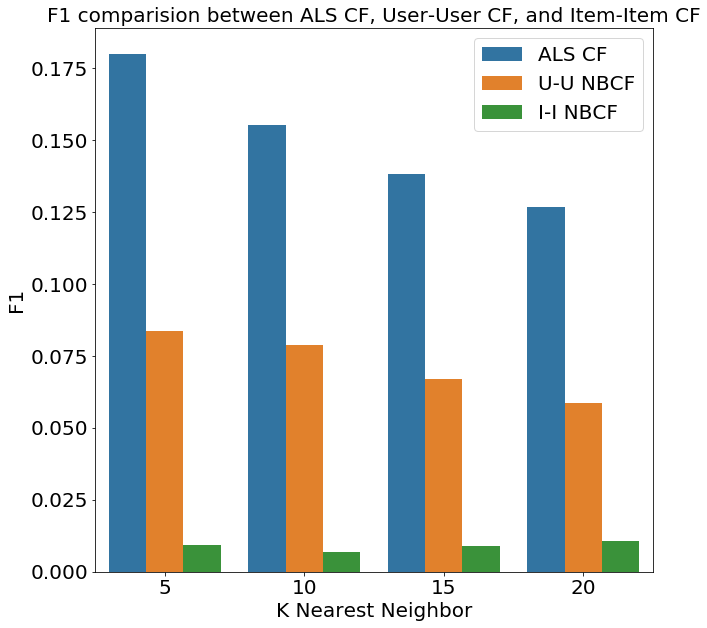

In [307]:
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(x="k", y="f1", hue="model", data=result_df, ax=ax)
ax.set_title("F1 comparision between ALS CF, User-User CF, and Item-Item CF", fontsize=20)
ax.tick_params(labelsize=20, which="both")
ax.set_ylabel('F1', fontsize=20)
ax.set_xlabel('K Nearest Neighbor', fontsize=20)
ax.legend(prop={"size":20});

In [308]:
fig.savefig('images/full_figure.png') 

# Draft

In [42]:
p_loc.max()

491

In [58]:
user_vecs = model_als.user_factors
item_vecs = model_als.item_factors

In [60]:
user_vecs.shape

(45, 256)

In [61]:
item_vecs.shape

(496, 256)

In [ ]:
implicit.als.AlternatingLeastSquares(factors=256, iterations=100, calculate_training_loss=True)

In [63]:
import pickle
import scipy.sparse as sparse

In [64]:
file = open("./model.pkl", "wb")
pickle.dump(model_als, file)

In [65]:
saved_model = pickle.load(open('./model.pkl', 'rb'))

In [66]:
test_data = processing_df(train_test_split_df)

C:\Users\NHAT TRUONG\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
p_ids = [int(idx) for idx, score in saved_model.similar_items(45, N=100)]45

[(45, 0.16196753),
 (312, 0.029362889),
 (262, 0.02922479),
 (76, 0.029164273),
 (270, 0.029163772),
 (460, 0.029135544),
 (142, 0.02913214),
 (210, 0.029078884),
 (349, 0.029063663),
 (104, 0.029053155),
 (209, 0.029044691),
 (143, 0.029039817),
 (290, 0.029032093),
 (170, 0.029016962),
 (269, 0.029008394),
 (216, 0.028985782),
 (293, 0.028976774),
 (347, 0.028963208),
 (244, 0.028961131),
 (218, 0.028945243),
 (285, 0.028933128),
 (259, 0.028931517),
 (432, 0.028931072),
 (182, 0.028922057),
 (350, 0.02888029),
 (277, 0.028860364),
 (82, 0.02885649),
 (86, 0.028825318),
 (93, 0.028824933),
 (219, 0.028824236),
 (33, 0.028822612),
 (27, 0.02881976),
 (329, 0.028818324),
 (287, 0.02881338),
 (117, 0.028808694),
 (283, 0.028808651),
 (18, 0.028805982),
 (302, 0.028805884),
 (428, 0.028792305),
 (444, 0.028774576),
 (53, 0.028774356),
 (477, 0.028767776),
 (42, 0.028765295),
 (208, 0.028756086),
 (330, 0.028750973),
 (75, 0.028746223),
 (440, 0.02873631),
 (352, 0.028736236),
 (403, 0.02

In [102]:
from google_images_download import google_images_download  
  
# creating object 
response = google_images_download.googleimagesdownload()  
  

def downloadimages(query): 
    # keywords is the search query 
    # format is the image file format 
    # limit is the number of images to be downloaded 
    # print urs is to print the image file url 
    # size is the image size which can 
    # be specified manually ("large, medium, icon") 
    # aspect ratio denotes the height width ratio 
    # of images to download. ("tall, square, wide, panoramic") 
    arguments = {"keywords": query, 
                 "format": "jpg", 
                 "limit":4, 
#                  "print_urls":True, 
                 "size": "medium", 
                 "aspect_ratio": "tall",
                 "type": "photo",
                 "output_directory": "./imgs",
                 "no_directory": True,
#                  "save_source": "imgsrc",
                 "silent_mode": True,
#                  "specific_site": "amazon.com",
                 "no_numbering": True}
    try: 
        return response.download(arguments) 
      
    # Handling File NotFound Error     
    except FileNotFoundError:  
        arguments = {"keywords": query, 
                     "format": "jpg", 
                     "limit":4, 
#                      "print_urls":True,  
                     "size": "medium",
                     "type": "photo",
                     "output_directory": "./imgs",
                     "no_directory": True,
#                      "save_source": "imgsrc",
                     "silent_mode": True,
#                      "specific_site": "amazon.com",
                     "no_numbering": True} 
                       
        # Providing arguments for the searched query 
        try: 
            # Downloading the photos based 
            # on the given arguments 
            return response.download(arguments)  
        except: 
            pass
  
temp_query = "furniture Diana Lounger F268"
path = downloadimages(temp_query)


In [103]:
path[0].get(temp_query)

['F:\\workspace\\RecSys_ecommerce\\recsys\\imgs\\page_1_thumb_large.jpg',
 'F:\\workspace\\RecSys_ecommerce\\recsys\\imgs\\1_8ff87a15-bcd6-4cfb-b843-45cf84ff0fbe_800x.jpg',
 'F:\\workspace\\RecSys_ecommerce\\recsys\\imgs\\1_c28872b0-ecd9-499d-8c18-e7020957c24b_800x.jpg',
 'F:\\workspace\\RecSys_ecommerce\\recsys\\imgs\\e80e62f7-9061-453a-8c30-048f47b2c3fc-image.jpg']

In [54]:
path[0].get(temp_query)[0].split("\\")[-1]

'2c834cd18803b483b587443976adea7d.jpg'

In [56]:
path[0].get(temp_query)[0]

'F:\\workspace\\RecSys_ecommerce\\recsys\\imgs\\2c834cd18803b483b587443976adea7d.jpg'

In [55]:
import glob
import shutil
import os

dst_dir = "./downloads"
for jpgfile in glob.iglob(path[0].get(temp_query)[0]):
    shutil.copy(jpgfile, dst_dir)